
# IceVision Bboxes - Real Data

*This is a mashup of IceVision's "[Custom Parser](https://airctic.com/0.8.0/custom_parser/)" example and their ["Getting Started (Object Detection)"](https://airctic.com/0.8.0/getting_started_object_detection/) notebooks, to analyze SPNet Real dataset, for which I [generated bounding boxes](https://github.com/drscotthawley/SPNet/blob/master/gen_bboxes_csv.py). -- S.H. Hawley, July 1, 2021*

## Installing IceVision and IceData
If on Colab run the following cell, else check the [installation instructions](https://airctic.com/dev/install/)

In [ ]:
# IceVision - IceData - MMDetection - YOLO v5 Installation
#try:
#    !wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
#    !chmod +x install_colab.sh && ./install_colab.sh
#except:
#    print("Ignore the error messages and just keep going")

In [ ]:
#all_slow

In [ ]:
!pip install espiownage -Uqq
from espiownage.core import *
sysinfo()

TORCH_VERSION=torch1.8.0; CUDA_VERSION=cu101
CUDA available = True, Device count = 1, Current device = 0
Device name = GeForce RTX 2080 Ti
hostname: lecun


In [ ]:
#skip
# FOR COLAB: Install IceVision, then grab latest and force a hard restart.
#  Locally, you can & should still run (most of) the install_colab.sh script
! [ -e /content ] &&  wget https://raw.githubusercontent.com/airctic/icevision/master/install_colab.sh
! [ -e /content ] &&  chmod +x install_colab.sh && ./install_colab.sh 
! [ -e /content ] &&  pip install git+git://github.com/airctic/icevision.git --upgrade && kill -9 -1

In [ ]:
from icevision.all import *
import pandas as pd

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/shawley/.icevision/mmdetection_configs/mmdetection_configs-2.10.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


The real test: if this next import doesn't pass then your IV install is old/messed up:

In [ ]:
from icevision.models.checkpoint import *

## Download dataset

We're going to be using a small sample of the chess dataset, the full dataset is offered by roboflow [here](https://public.roboflow.com/object-detection/chess-full)

In [ ]:
#data_url = "https://github.com/airctic/chess_sample/archive/master.zip"
#data_dir = icedata.load_data(data_url, 'chess_sample') / 'chess_sample-master'

# SPNET Real Dataset link (currently proprietary, thus link may not work)
#data_url = "https://hedges.belmont.edu/~shawley/spnet_sample-master.zip"
#data_dir = icedata.load_data(data_url, 'spnet_sample') / 'spnet_sample-master' 

# public espiownage cyclegan dataset:
#data_url = 'https://hedges.belmont.edu/~shawley/espiownage-cyclegan.tgz'
#data_dir = icedata.load_data(data_url, 'espiownage-cyclegan') / 'espiownage-cyclegan'

# real data, cleaned
#data_url = 'https://hedges.belmont.edu/~shawley/espiownage-cleaner.tgz'
#data_dir = icedata.load_data(data_url, 'espiownage-cleaner') / 'espiownage-cleaner'


# local data already there:
from pathlib import Path
data_dir = Path('/home/shawley/datasets/espiownage-cleaner')  # real data is local and private

## Understand the data format

In this task we were given a `.csv` file with annotations, let's take a look at that.

In [ ]:
df = pd.read_csv(data_dir / "bboxes/annotations.csv")
# shuffle rows: if you don't do this next line then my manual/DIY k-folding will go badly
df = df.sample(frac=1).reset_index(drop=True)  
df.head()

filename  width  height  label  xmin  ymin  xmax  ymax
0  06240907_proc_00662.png    512     384     11     0    88   180   331
1  06241902_proc_00828.png    512     384      2   151   240   256   329
2  06241902_proc_00790.png    512     384      2   141   251   256   338
3  06240907_proc_00776.png    512     384      2   259   283   368   378
4  06240907_proc_01395.png    512     384      1   217     6   284   105

At first glance, we can make the following assumptions:  

  * Multiple rows with the **same** filename, width, height  
  * A **label** for each row
  * A **bbox** [xmin, ymin, xmax, ymax] for each row  
  
Once we know what our data provides we can create our custom `Parser`.  

In [ ]:
set(np.array(df['label']).flatten())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

In [ ]:
# Let's just make them all the same object:
df['label'] = 'AN'  # antinode
df.head()

filename  width  height label  xmin  ymin  xmax  ymax
0  06240907_proc_00662.png    512     384    AN     0    88   180   331
1  06241902_proc_00828.png    512     384    AN   151   240   256   329
2  06241902_proc_00790.png    512     384    AN   141   251   256   338
3  06240907_proc_00776.png    512     384    AN   259   283   368   378
4  06240907_proc_01395.png    512     384    AN   217     6   284   105

## Create the Parser

The first step is to create a template record for our specific type of dataset, in this case we're doing standard object detection:

In [ ]:
template_record = ObjectDetectionRecord()

Now use the method `generate_template` that will print out all the necessary steps we have to implement.

In [ ]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_img_size(<ImgSize>)
        record.set_filepath(<Union[str, Path]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)
        record.detection.add_bboxes(<Sequence[BBox]>)


We can copy the template and use it as our starting point. Let's go over each of the methods we have to define:

- `__init__`: What happens here is completely up to you, normally we have to pass some reference to our data, `data_dir` in our case.

- `__iter__`: This tells our parser how to iterate over our data, each item returned here will be passed to `parse_fields` as `o`. In our case we call `df.itertuples` to iterate over all `df` rows.

- `__len__`: How many items will be iterating over.

- `imageid`: Should return a `Hashable` (`int`, `str`, etc). In our case we want all the dataset items that have the same `filename` to be unified in the same record.

- `parse_fields`: Here is where the attributes of the record are collected, the template will suggest what methods we need to call on the record and what parameters it expects. The parameter `o` it receives is the item returned by `__iter__`.

!!! danger "Important"  
    Be sure to pass the correct type on all record methods!

In [ ]:
class BBoxParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record=template_record)
        
        self.data_dir = data_dir
        self.df = pd.read_csv(data_dir / "bboxes/annotations.csv")
        self.df['label'] = 'AN'  # make them all the same object
        # shuffle rows: if you don't do this next line then my manual/DIY k-folding will go badly
        self.df = self.df.sample(frac=1).reset_index(drop=True)  # shuffle rows
        self.class_map = ClassMap(list(self.df['label'].unique()))
        
    def __iter__(self) -> Any:
        for o in self.df.itertuples():
            yield o
        
    def __len__(self) -> int:
        return len(self.df)
        
    def record_id(self, o) -> Hashable:
        return o.filename
        
    def parse_fields(self, o, record, is_new):
        if is_new:
            record.set_filepath(self.data_dir / 'images' / o.filename)
            record.set_img_size(ImgSize(width=o.width, height=o.height))
            record.detection.set_class_map(self.class_map)
        
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

parser = BBoxParser(template_record, data_dir)

## Split the Dataset: Random or K-fold


In [ ]:
kfold = True 
if not kfold: 
    print("\n------\n Random splitting")
    parser = BBoxParser(template_record, data_dir)
else:
    k = 0  # manual k-folding index -- change this yourself k = 0 to (nk-1)
    nk = 5 # number of k-folds
    print(f"\n-----\n K-fold splitting: {k+1}/{nk}")
    n = len(df)
    idmap, indlist = IDMap(list(df['filename'][0:n])), list(range(n))
    val_size = int(round(n/nk))

    if k < nk-1:
        val_list = indlist[k*val_size:(k+1)*val_size]
        train_list = indlist[0:k*val_size] + indlist[(k+1)*val_size:n]
    else:   # last one might be a bit different
        val_list = indlist[k*val_size:]
        train_list = indlist[0:-len(val_list)]
    val_id_list = list([df['filename'][i] for i in val_list])
    train_id_list = list([df['filename'][i] for i in train_list])
    presplits = list([train_id_list,val_id_list])
    train_records, valid_records = parser.parse(data_splitter=FixedSplitter(presplits))

  0%|          | 0/6309 [00:00<?, ?it/s]

INFO     - Autofixing records | icevision.parsers.parser:parse:122


  0%|          | 0/1955 [00:00<?, ?it/s]

Let's take a look at one record:

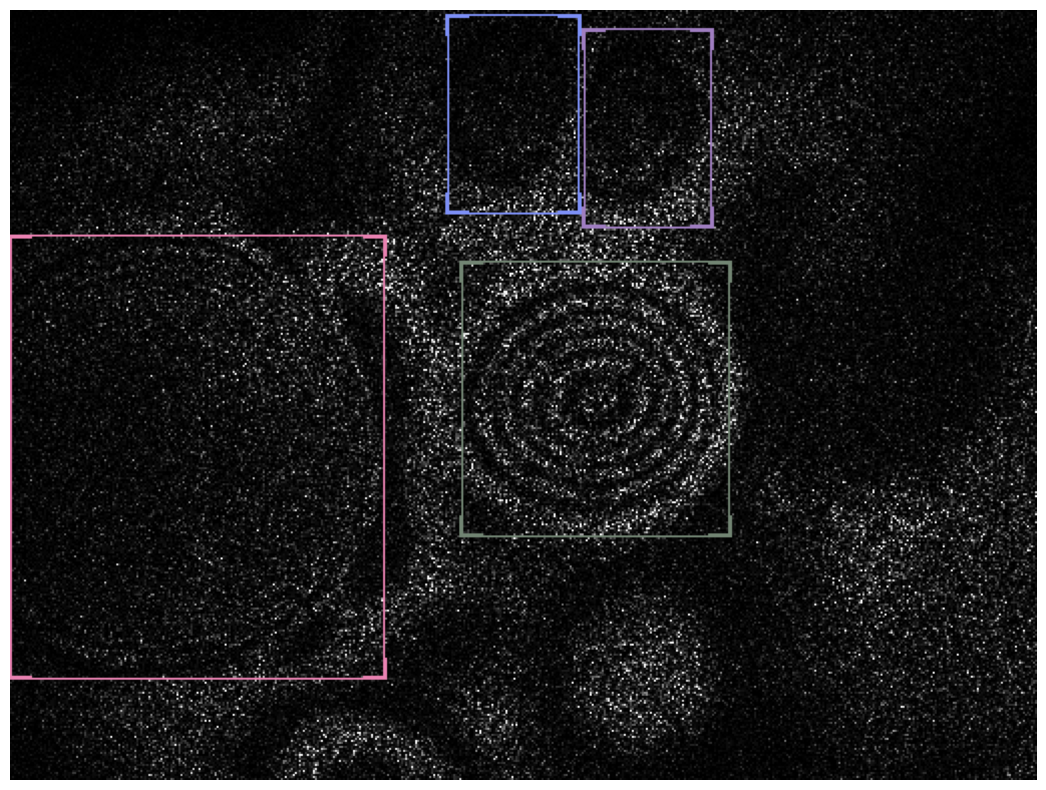

In [ ]:
show_record(train_records[5], display_label=False, figsize=(14, 10))

In [ ]:
train_records[0]

BaseRecord

common: 
	- Record ID: 06240907_proc_00591.png
	- Image size ImgSize(width=512, height=384)
	- Filepath: /home/shawley/datasets/espiownage-cleaner/images/06240907_proc_00591.png
	- Img: None
detection: 
	- Class Map: <ClassMap: {'background': 0, 'AN': 1}>
	- Labels: [1, 1, 1, 1, 1]
	- BBoxes: [<BBox (xmin:0, ymin:101, xmax:184, ymax:334)>, <BBox (xmin:257, ymin:288, xmax:354, ymax:367)>, <BBox (xmin:279, ymin:16, xmax:352, ymax:107)>, <BBox (xmin:224, ymin:130, xmax:353, ymax:259)>, <BBox (xmin:216, ymin:4, xmax:285, ymax:87)>]

## Moving On...
*Following the Getting Started "refrigerator" notebook...*

In [ ]:
# Transforms
# size is set to 384 because EfficientDet requires its inputs to be divisible by 128
image_size = 384  
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

# Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

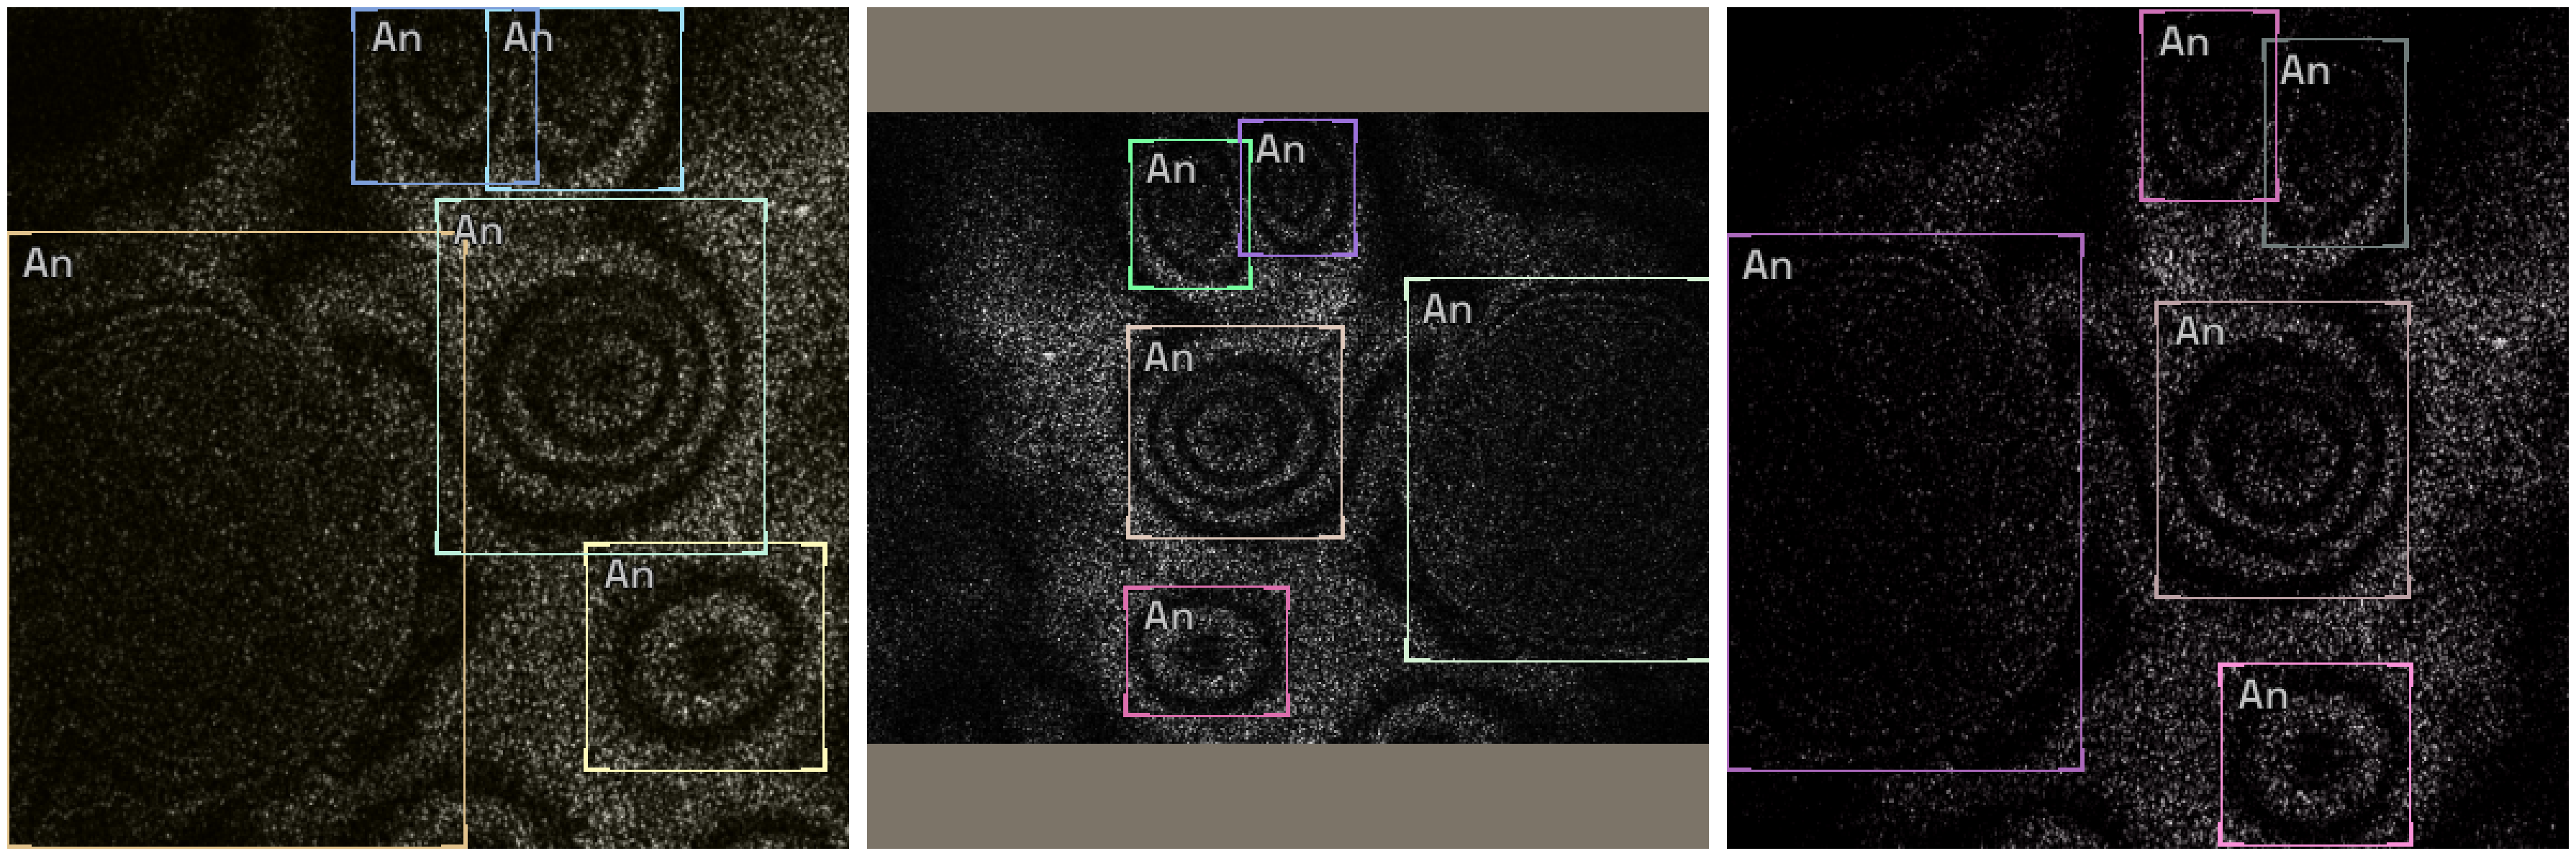

In [ ]:
# Show an element of the train_ds with augmentation transformations applied
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

In [ ]:
# Just change the value of selection to try another model

selection = 0

extra_args = {}

if selection == 0:
  model_type = models.mmdet.retinanet
  backbone = model_type.backbones.resnet50_fpn_1x

elif selection == 1:
  # The Retinanet model is also implemented in the torchvision library
  model_type = models.torchvision.retinanet
  backbone = model_type.backbones.resnet50_fpn

elif selection == 2:
  model_type = models.ross.efficientdet
  backbone = model_type.backbones.tf_lite0
  # The efficientdet model requires an img_size parameter
  extra_args['img_size'] = image_size

elif selection == 3:
  model_type = models.ultralytics.yolov5
  backbone = model_type.backbones.small
  # The yolov5 model requires an img_size parameter
  extra_args['img_size'] = image_size

model_type, backbone, extra_args

(<module 'icevision.models.mmdet.models.retinanet' from '/home/shawley/envs/iv2/lib/python3.8/site-packages/icevision/models/mmdet/models/retinanet/__init__.py'>,
 {})

In [ ]:
# Instantiate the mdoel
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.retina_cls.weight: copying a param with shape torch.Size([720, 256, 3, 3]) from checkpoint, the shape in current model is torch.Size([9, 256, 3, 3]).
size mismatch for bbox_head.retina_cls.bias: copying a param with shape torch.Size([720]) from checkpoint, the shape in current model is torch.Size([9]).


/home/shawley/envs/iv2/lib/python3.8/site-packages/mmcv/cnn/utils/weight_init.py:118: UserWarning: init_cfg without layer key, if you do not define override key either, this init_cfg will do nothing
  warnings.warn(


In [ ]:
# Data Loaders
train_dl = model_type.train_dl(train_ds, batch_size=8, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=8, num_workers=4, shuffle=False)

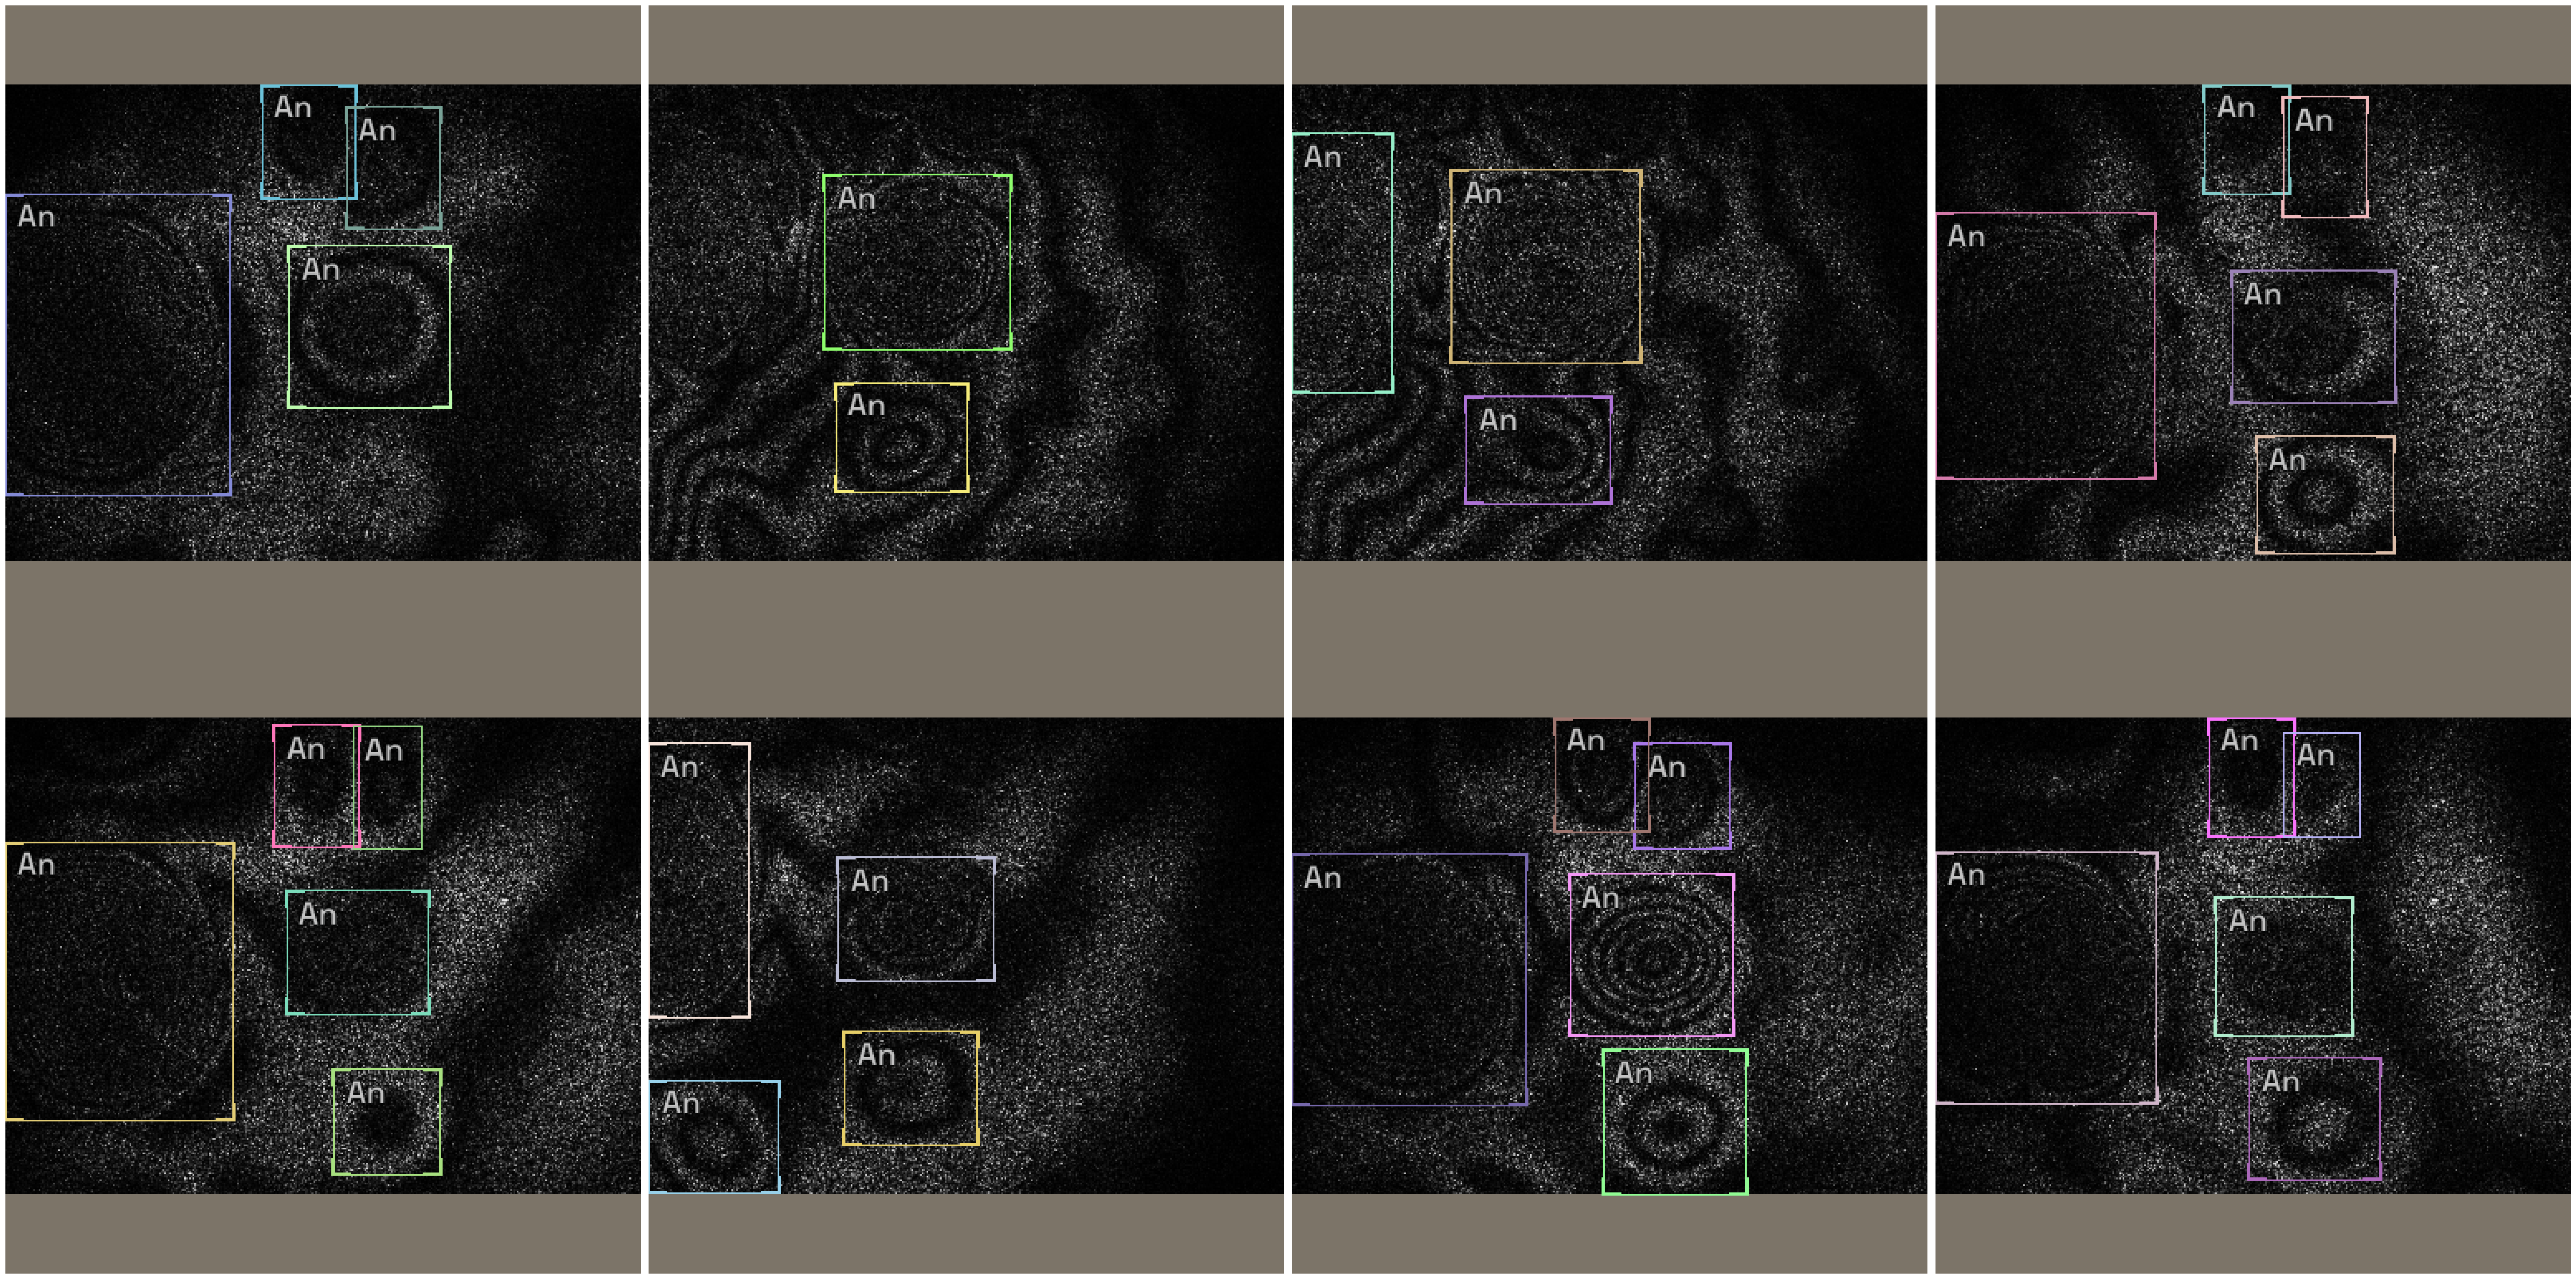

In [ ]:
# show batch - target data -- Ideally these won't all look the same! ;-) 
model_type.show_batch(first(valid_dl), ncols=4)

In [ ]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [ ]:
# use the fastai bindings
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

SuggestedLRs(lr_min=0.0002612352604046464, lr_steep=0.00012627581600099802)

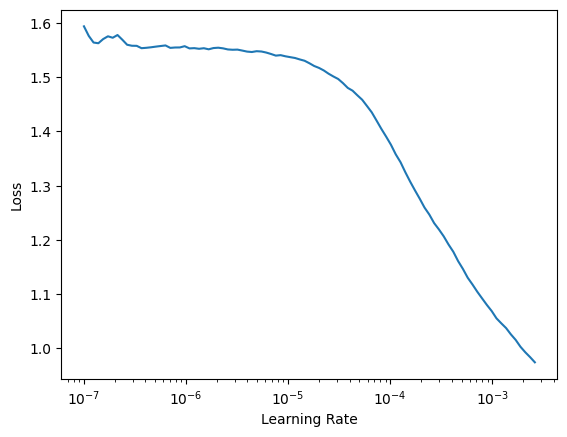

In [ ]:
learn.lr_find(end_lr=0.005)

# For Sparse-RCNN, use lower `end_lr`
# learn.lr_find(end_lr=0.005)

In [ ]:
epochs = 11 if kfold else 30   # go faster for kfold; 10 is good enough ;-)
freeze_epochs=2
print(f"Training for {epochs} epochs, starting with {freeze_epochs} frozen epochs...")
learn.fine_tune(epochs, 1e-4, freeze_epochs=2)

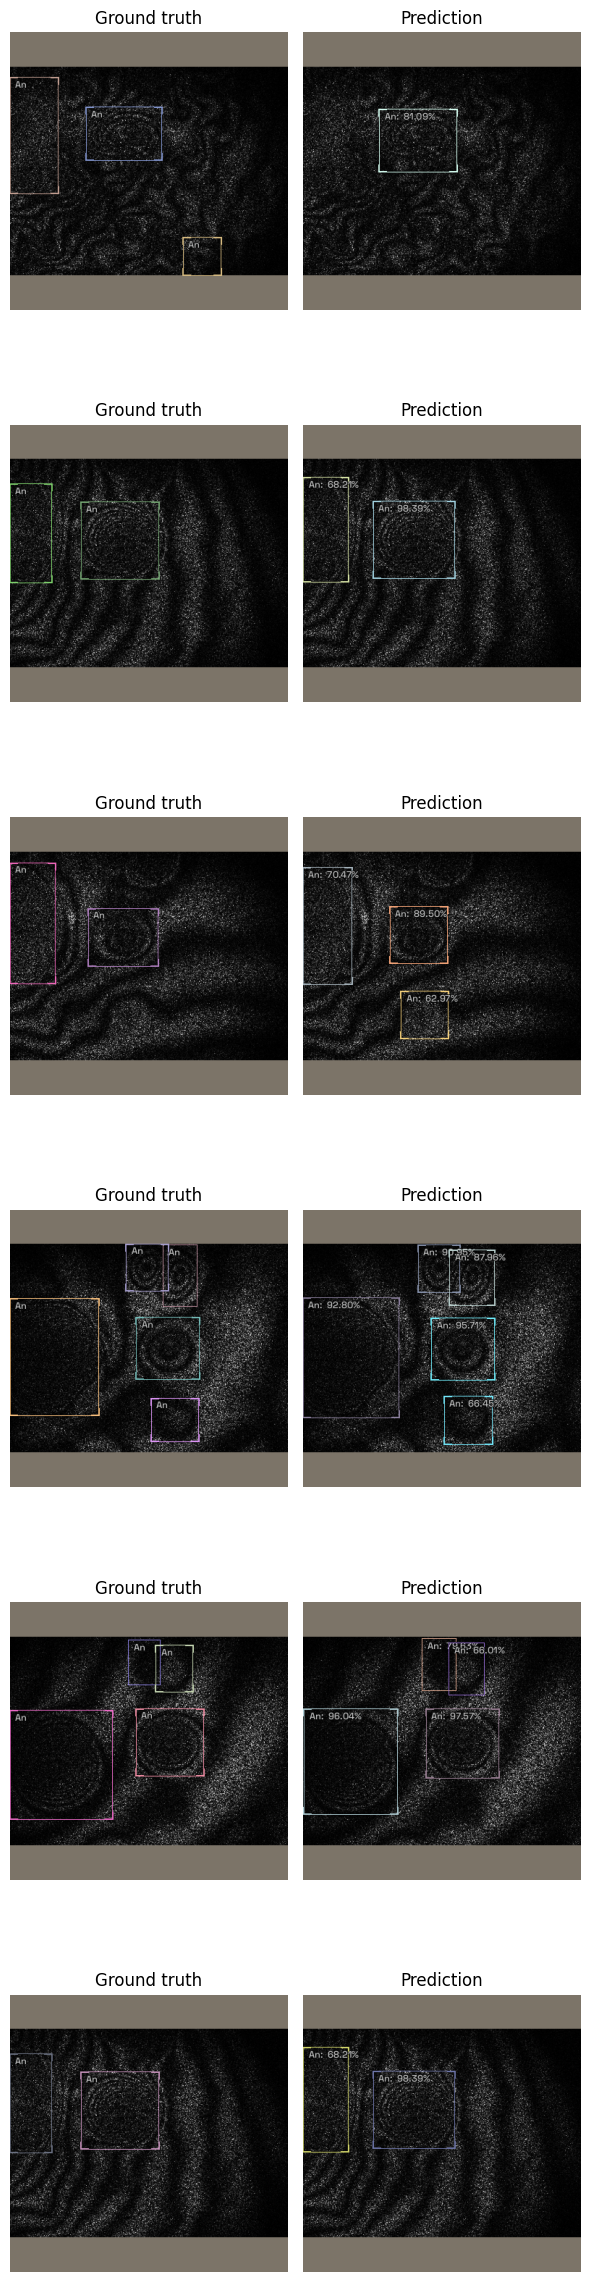

In [ ]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

In [ ]:
checkpoint_path = f'espi-retinanet-checkpoint-real-k{k}.pth'

save_icevision_checkpoint(model, 
                        model_name='mmdet.retinanet', 
                        backbone_name='resnet50_fpn_1x',
                        classes =  parser.class_map.get_classes(), 
                        img_size=384, 
                        filename=checkpoint_path,
                        meta={'icevision_version': '0.9.1'})

## Inference
Might get a CUDA OOM error here. If so, restart kernel and load what we just saved. You'll have to go back and re-define learn, model, valid_ds etc., though. 

In [ ]:
checkpoint_and_model = model_from_checkpoint(checkpoint_path, 
    model_name='mmdet.retinanet', 
    backbone_name='resnet50_fpn_1x',
    img_size=384) 

model.to('cuda')
device=next(model.parameters()).device
device

Use load_from_local loader


device(type='cuda', index=0)

In [ ]:
infer_ds = valid_ds
infer_dl = model_type.infer_dl(infer_ds, batch_size=4, shuffle=False)
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)
#Do NOT use: preds = model_type.predict(model, valid_ds, keep_images=True)

  0%|          | 0/243 [00:00<?, ?it/s]

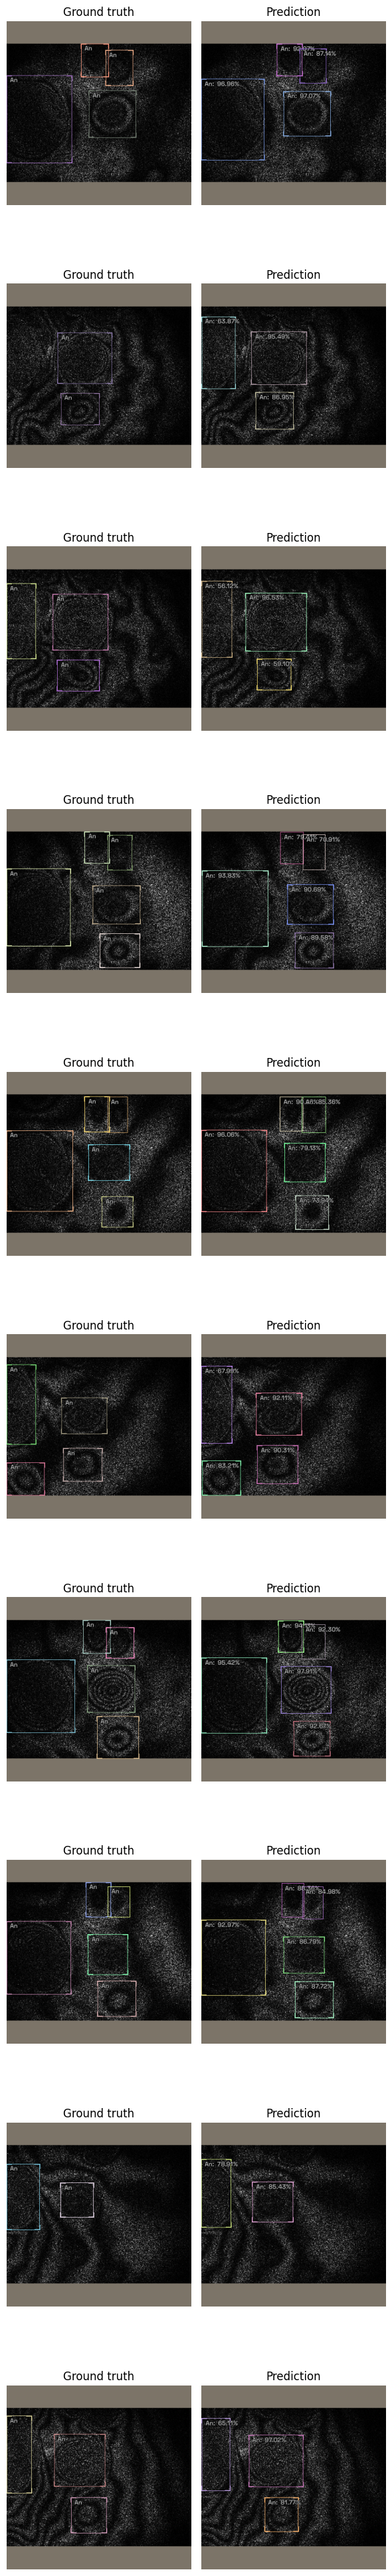

In [ ]:
show_preds(preds=preds[0:10])

In [ ]:
len(train_ds), len(valid_ds), len(preds)

(1904, 970, 970)

let's try to figure out how to get what we want from these predictions.  hmmm

In [ ]:
preds[0].pred

BaseRecord

common: 
	- Image size ImgSize(width=384, height=384)
	- Record ID: 06240907_proc_00662.png
	- Img: 384x384x3 <np.ndarray> Image
detection: 
	- Class Map: <ClassMap: {'background': 0, 'AN': 1}>
	- Labels: [1, 1, 1, 1]
	- BBoxes: [<BBox (xmin:171.94126892089844, ymin:147.066650390625, xmax:268.5628662109375, ymax:240.49044799804688)>, <BBox (xmin:0.0, ymin:121.89667510986328, xmax:130.89022827148438, ymax:290.69158935546875)>, <BBox (xmin:157.9577178955078, ymin:48.444435119628906, xmax:209.6389923095703, ymax:115.0048599243164)>, <BBox (xmin:205.478759765625, ymin:58.77273941040039, xmax:259.417236328125, ymax:130.2951202392578)>]
	- Scores: [    0.97066     0.96958     0.92969     0.87138]

In [ ]:
preds[1].pred.detection.scores

array([     0.9549,     0.86953,     0.63871], dtype=float32)

In [ ]:
preds[1].pred.detection.bboxes

[<BBox (xmin:104.32266235351562, ymin:100.92418670654297, xmax:218.78952026367188, ymax:210.76654052734375)>,
 <BBox (xmin:113.4362564086914, ymin:226.69371032714844, xmax:191.94189453125, ymax:303.52825927734375)>,
 <BBox (xmin:1.1537857055664062, ymin:69.0500717163086, xmax:70.78915405273438, ymax:219.51254272460938)>]

In [ ]:
preds[1].pred.detection.bboxes[0].xmin

def get_bblist(pred):
    my_bblist = []
    bblist = pred.pred.detection.bboxes
    for i in range(len(bblist)):
        my_bblist.append([bblist[i].xmin, bblist[i].ymin, bblist[i].xmax, bblist[i].ymax])
    return my_bblist

get_bblist(preds[1])      

[[104.32266, 100.92419, 218.78952, 210.76654],
 [113.43626, 226.69371, 191.9419, 303.52826],
 [1.1537857, 69.05007, 70.789154, 219.51254]]

In [ ]:
preds[3].pred

BaseRecord

common: 
	- Record ID: 06240907_proc_00776.png
	- Image size ImgSize(width=384, height=384)
	- Img: 384x384x3 <np.ndarray> Image
detection: 
	- Scores: [    0.93831     0.90691     0.89576      0.7941     0.70914]
	- Class Map: <ClassMap: {'background': 0, 'AN': 1}>
	- Labels: [1, 1, 1, 1, 1]
	- BBoxes: [<BBox (xmin:2.2850189208984375, ymin:129.50161743164062, xmax:138.73626708984375, ymax:287.3768615722656)>, <BBox (xmin:179.84140014648438, ymin:158.60604858398438, xmax:274.914794921875, ymax:241.73519897460938)>, <BBox (xmin:195.30435180664062, ymin:258.6470031738281, xmax:274.643310546875, ymax:332.4682312011719)>, <BBox (xmin:164.3509063720703, ymin:49.7545166015625, xmax:212.33836364746094, ymax:115.15544128417969)>, <BBox (xmin:211.33731079101562, ymin:54.650238037109375, xmax:257.5757141113281, ymax:127.51445007324219)>]

In [ ]:
results = []
for i in range(len(preds)):
    if (len(preds[i].pred.detection.scores) == 0): continue   # sometimes you get a zero box/prediction. ??
    #print(f"i = {i}, file = {str(Path(valid_ds[i].common.filepath).stem)+'.csv'}, bboxes = {get_bblist(preds[i])}, scores={preds[i].pred.detection.scores}\n")
    worst_score = np.min(np.array(preds[i].pred.detection.scores))
    line_list = [str(Path(valid_ds[i].common.filepath).stem)+'.csv', get_bblist(preds[i]), preds[i].pred.detection.scores, worst_score, i]
    results.append(line_list)
    
# store as pandas dataframe
res_df = pd.DataFrame(results, columns=['filename', 'bblist','scores','worst_score','i'])
res_df = res_df.sort_values('worst_score')  # order by worst score as a "top losses" kind of thing
res_df.head() # take a look

filename  \
385  06240907_proc_00973.csv   
472  06241902_proc_01305.csv   
312  06240907_proc_00292.csv   
703  06241902_proc_01802.csv   
542  06240907_proc_00580.csv   

                                                                                                                                                                                                                                                                                                                             bblist  \
385                                                                                                                                                                                         [[163.79924, 134.47836, 275.4303, 244.87671], [0.8026047, 126.37773, 139.32632, 292.40704], [190.97601, 264.7258, 258.71545, 333.8126]]   
472                                                                                                                                                                                         [[108.70906, 101.53219, 218.08482, 217.0892], [1.9381962, 84.965996, 59.986267, 231.3284], [123.28911, 228.08128, 180.5442, 284.22955]]   
312                                                                                                                                          [[2.6407547, 122.064354, 147.58685, 295.88235], [201.03159, 185.91422, 252.44965, 245.18521], [224.0113, 154.67923, 284.4107, 211.29602], [150.4933, 238.28488, 204.63936, 293.23886]]   
703                                                                                                                                                                                                                                       [[100.36381, 108.06838, 212.20728, 214.30856], [0.3653469, 75.12563, 58.0689, 230.51862]]   
542  [[166.64502, 139.25168, 272.06723, 240.16678], [199.38095, 262.43307, 269.6079, 333.44827], [209.20874, 55.649307, 256.18094, 127.14867], [1.7261848, 138.99355, 116.95537, 281.23218], [163.15091, 50.10095, 212.35336, 118.81209], [0.55441284, 184.34184, 75.460976, 283.9815], [38.83757, 141.32932, 130.9435, 252.63617]]   

                                                                           scores  \
385                                           [0.9729451, 0.94984376, 0.50001764]   
472                                            [0.97011507, 0.5928285, 0.5002006]   
312                                 [0.960453, 0.72788745, 0.6765359, 0.50031626]   
703                                                        [0.9819204, 0.5004542]   
542  [0.9669667, 0.9094971, 0.80517113, 0.75459, 0.7254705, 0.5280292, 0.5005095]   

     worst_score    i  
385     0.500018  385  
472     0.500201  472  
312     0.500316  312  
703     0.500454  703  
542     0.500510  542

In [ ]:
if not kfold:
    res_df.to_csv('bboxes_top_losses_real.csv', index=False)
else:
    res_df.to_csv(f'bboxes_top_losses_real_k{k}.csv', index=False)